# Firefox engineering bug-to-nightly lead time trends

In [108]:
import pandas as pd
import seaborn as sns

In [109]:
files = ['data/nightly-{}{}.parq'.format(y, m)
         for y in (2016, 2017, 2018) 
         for m in ('01', '02', '03')]

In [110]:
df = pd.concat([pd.read_parquet(fn) for fn in files], ignore_index=True)
df.shape

(40092, 8)

In [111]:
df.dtypes

changeset                            object
changeset_desc                       object
changeset_pushid                     object
changeset_pushtime           datetime64[ns]
bug                                 float64
bug_creation_time            datetime64[ns]
nightly_build_id                     object
nightly_publish_time    datetime64[ns, UTC]
dtype: object

In [112]:
df['bug_creation_time'] = df['bug_creation_time'].dt.tz_localize('UTC')

In [113]:
df['duration'] = df['nightly_publish_time'] - df['bug_creation_time']
df['duration'].min()

Timedelta('-640 days +19:15:17')

In [114]:
# Scrub negative bug creation times
df = df.drop(df[df['duration'].dt.days < 0].index)
df['duration'].min()

Timedelta('0 days 02:04:33')

In [115]:
grouped = df.groupby(df['nightly_publish_time'].dt.year)

In [116]:
print("Number of unique builds per year")
grouped['nightly_build_id'].nunique()

Number of unique builds per year


nightly_publish_time
2016     85
2017     88
2018    167
Name: nightly_build_id, dtype: int64

In [117]:
grouped['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
nightly_publish_time,,,,,,,,
2016,11793,269 days 02:33:50.001865,976 days 01:03:51.380716,0 days 06:39:46,4 days 08:44:29,14 days 10:48:00,77 days 12:36:22,6162 days 07:45:10
2017,16166,1320 days 23:30:53.659841,2470 days 11:53:52.703041,0 days 03:24:37,6 days 04:12:13.250000,27 days 03:24:11,405 days 22:59:37.500000,7067 days 22:14:58
2018,12132,374 days 05:54:18.406116,1306 days 18:03:09.246195,0 days 02:04:33,3 days 05:19:08,12 days 19:18:13,66 days 02:14:15,6694 days 13:57:22


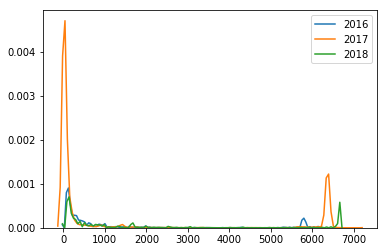

In [118]:
for year, data in grouped['duration']:
    sns.kdeplot(data.dt.days, label=year)

## Bugs filed within 90 days

Focus on bugs filed within 90 days of the code landing that addresses them.  That range describes the majority of code landings.

In [119]:
last90 = df[df['duration'].dt.days <= 90]

In [120]:
grouped = last90['duration'].groupby(last90['nightly_publish_time'].dt.year)

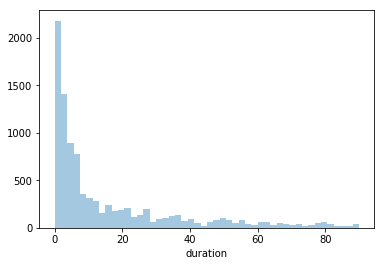

In [121]:
sns.distplot(grouped.get_group(2018).dt.days, kde=False);

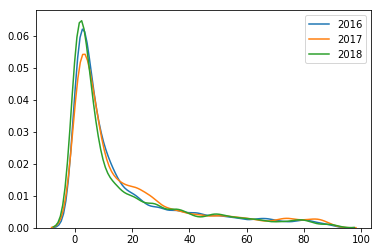

In [122]:
for year, data in grouped:
    sns.kdeplot(data.dt.days, label=year)

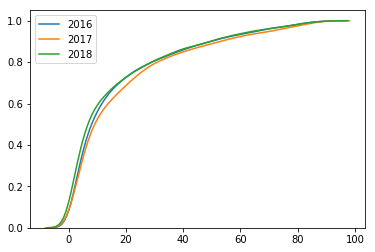

In [123]:
for year, data in grouped:
    sns.kdeplot(data.dt.days, label=year, cumulative=True)